In [1]:
import shapely.geometry
import pyproj
import osmnx as ox
import geopandas as gpd
#from mpl_toolkits.basemap import Basemap  #installing basemap along with geopandas/osmnx created big issues in the env
import pandas as pd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

from shapely.geometry import Point
ox.settings.use_cache=True
ox.settings.log_console=True

C:\Users\isaldiviagonzatti\anaconda3\envs\geoenv\lib\site-packages\pyproj\__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Create a regular spaced grid for the are of interest

In [4]:
#solution from https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

# Set up transformers 'epsg:32616' is for Costa Rica
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:32616')
to_original_transformer = pyproj.Transformer.from_crs('epsg:32616', 'epsg:4326')

# Create corners of rectangle to be transformed to a grid. Defined by limits of area with PA fields
                                                     
sw = shapely.geometry.Point((10.09,-85.07)) #south, west
ne = shapely.geometry.Point((11.04, -83.40)) #north, east

stepsize = 5000 # 5 km grid step size


In [6]:
# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform sw points to 32616
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for ne

In [7]:
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

with open('latloncandid.csv', 'w') as of:
    of.write('lon;lat\n')
    for p in gridpoints:
        of.write('{:f};{:f}\n'.format(p.x, p.y))

In [8]:
#read the created file containing the lat lon points and transform to geodataframe
df = pd.read_csv("latloncandid.csv", delimiter=';', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]
gdf = GeoDataFrame(df, geometry=geometry)   

In [5]:
#import shp of Costa Rica
crShape = gpd.read_file(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/raw/geoCR.geojson')

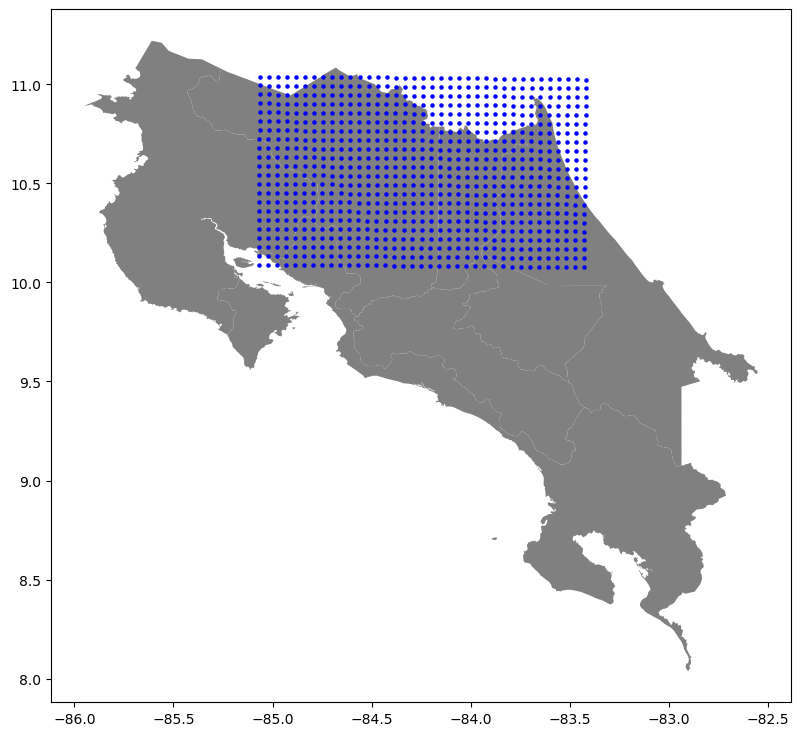

In [10]:
#Plot the generated grid
gdf.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5);

### We are not interested in the grid points outside the country

In [11]:
gdf = gdf.set_crs('epsg:4326')

In [12]:
candidates = gpd.sjoin(gdf, crShape, how='inner') 

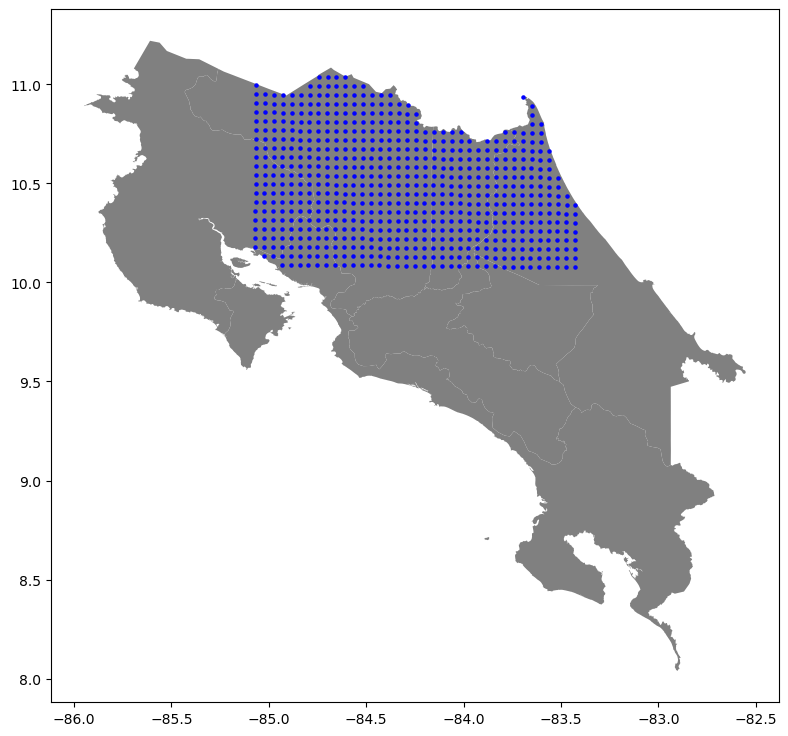

In [13]:
#Plot created grid
candidates.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5);

In [19]:
#candidates.to_file(r"C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/candidates.geojson", driver='GeoJSON')
candidates = gpd.read_file(r"C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/candidates.geojson")

In [10]:
## path to PA fields and network
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/cr_allPrivate.gpkg'

In [11]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [12]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [27]:
G_proj = ox.project_graph(G)

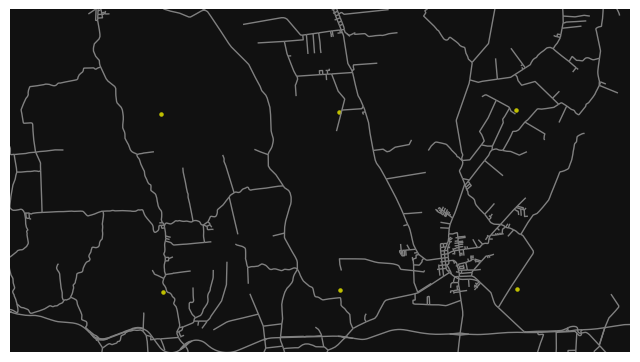

In [26]:
fig, ax = ox.plot_graph(G, edge_color='grey', edge_linewidth=1, node_size=0, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='b', s=5, zorder=-1)

In [47]:
# project graph and points to same CRS
geom = gpd.points_from_xy(candidates['geometry'].x, candidates['geometry'].y)
gdf = gpd.GeoDataFrame(candidates, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [54]:
%%time
# calculate nearest edge to each point
neCan = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)

CPU times: total: 2.59 s
Wall time: 2.66 s


In [56]:
unique_edges=neCan[0]

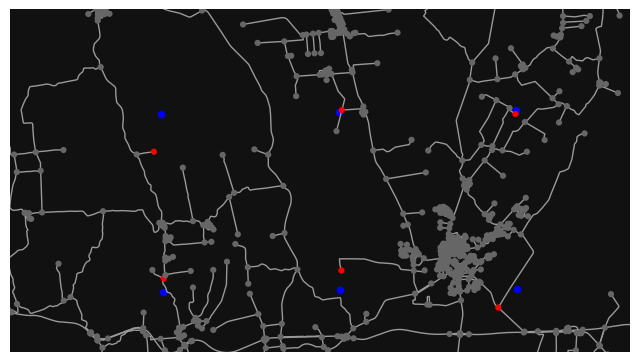

In [57]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=20, zorder=-1)

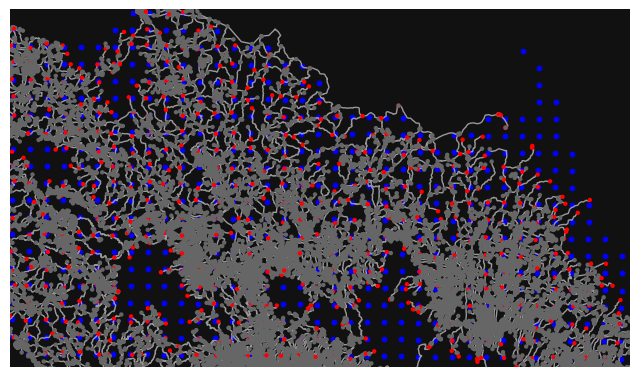

In [61]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec,node_size=10, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=10, zorder=-5)

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(8, 6.5)

# m = Basemap(projection='lcc', lat_0 = 9., lon_0 = -85,
#     resolution = 'i', area_thresh = 0.1,
#     llcrnrlon=-87, llcrnrlat=9,
#     urcrnrlon=-82, urcrnrlat=13)
 
# m.drawcoastlines()
# m.bluemarble()

# x,y = m(df['lat'],  df['lon'])
# m.scatter(x, y, marker='o', color='Red',s=5)
 
# plt.show()